# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance
import pickle

import warnings
warnings.filterwarnings('ignore')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Data Preparation 

In [33]:

# Attributes Values
data_root = 'data'

# import attributes files and forward fill attribute names
attr_val = pd.read_excel(os.path.join(data_root, 'DIAS Attributes - Values 2017.xlsx'), usecols='B:E', dtype='str').fillna(method='ffill')
attr_val.columns = attr_val.iloc[0]
attr_val = attr_val.iloc[1:]
attr_val = attr_val.drop(['Description'], axis=1)

# Remove _RZ from the dataframe as it creates inconsistencies with the azdias data
attr_val['Attribute'] = attr_val['Attribute'].str.replace('_RZ', '')


#### Function used:

In [59]:

def convertUnknownToNan(df, attr_val):
    '''
    Converts unknown values (based on the attribute file given by Arvato) to NaN.
    
    Input:
        - df: DataFrame we want to replace the unknown values
        - attr_val: DataFrame from the attribute file with Meaning and Attribute columns
        
    Output:
        - df: DataFrame with NaN values instead of unknown
    '''
    for _, row in attr_val[attr_val['Meaning'].isin(['unknown', 'unknown / no main age detectable'])].iterrows():
        
        key, val = row['Attribute'], dict()
        for x in row['Value'].split(', '):
            val[int(x)] = np.nan

        if key in df.columns:
            df = df.replace({key: val})
    return df


def removeNan(df, col_null_names=['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'EINGEFUEGT_AM']):

    '''
    Removes columns with high percent of NaN values
    
    Input:
        - df: DataFrame we want to remove NaN columns
        - col_null_names: Columns with high percent of NaN values
    
    Output:
        - df: DataFrame without the NaN columns
    '''
    
    return df.drop(col_null_names, axis=1)


def cleanCategorical(df, modes, create_modes=False):
    '''
    Fixes categorical variables by using one-hot encoding, and converting string values to numerical. 
    Detailed description is provided in the "Data Understanding" section below
    
    Input:
        - df: 
    
    '''
    # replace 'X' to NaN
    replace_dict = {'CAMEO_DEU_2015': {'XX': np.nan}, 'CAMEO_DEUG_2015': {'X': np.nan}, 'CAMEO_INTL_2015': {'XX': np.nan}}
    for key, val in replace_dict.items():
        if key in df.columns:
            df = df.replace({key: val})

    # CAMEO_DEU_2015
    # Encode get dumies column
    cam = pd.get_dummies(df['CAMEO_DEU_2015'], prefix='CAMEO_DEU_2015', dummy_na=False).astype('int64')
    df = pd.concat([df, cam], axis=1)

    # CAMEO_DEUG_2015
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].map(lambda x: int(x), na_action='ignore')
    # find modes to fill NA
    if create_modes:
        modes['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].mode().values[0]
        
    # Fill NA with modes
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].fillna(modes['CAMEO_DEUG_2015'])
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('int64')

    # CAMEO_INTL_2015 will be split in two features
    df['CAMEO_INTL_2015_1'] = df['CAMEO_INTL_2015'].map(
        lambda x: int(int(x)/10), na_action='ignore')
    if create_modes:
        modes['CAMEO_INTL_2015_1'] = df['CAMEO_INTL_2015_1'].mode().values[0]
    df['CAMEO_INTL_2015_1'] = df['CAMEO_INTL_2015_1'].fillna(modes['CAMEO_INTL_2015_1'])
    df['CAMEO_INTL_2015_1'] = df['CAMEO_INTL_2015_1'].astype('int64')

    df['CAMEO_INTL_2015_2'] = df['CAMEO_INTL_2015'].map(lambda x: int(x) % 10, na_action='ignore')
    if create_modes:
        modes['CAMEO_INTL_2015_2'] = df['CAMEO_INTL_2015_2'].mode().values[0]
    df['CAMEO_INTL_2015_2'] = df['CAMEO_INTL_2015_2'].fillna(modes['CAMEO_INTL_2015_2'])
    df['CAMEO_INTL_2015_2'] = df['CAMEO_INTL_2015_2'].astype('int64')

    # D19_LETZTER_KAUF_BRANCHE
    d19 = pd.get_dummies(df['D19_LETZTER_KAUF_BRANCHE'], prefix='D19_LETZTER_KAUF_BRANCHE', dummy_na=False)
    d19 = d19.astype('int64')
    df = pd.concat([df, d19], axis=1)

    # OST_WEST_KZ
    if create_modes:
        modes['OST_WEST_KZ'] = df['OST_WEST_KZ'].mode().values[0]
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].fillna(modes['OST_WEST_KZ'])
    df = pd.concat([df, pd.get_dummies(df['OST_WEST_KZ'], prefix='OST_WEST_KZ', dummy_na=False)], axis=1)
    df['OST_WEST_KZ_W'] = df['OST_WEST_KZ_W'].astype('int64')

    df.drop(['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'OST_WEST_KZ','OST_WEST_KZ_O', 'D19_LETZTER_KAUF_BRANCHE'], axis=1, inplace=True)

    return df, modes


def cleanNumerical(df, modes, create_modes=False):
    '''
    Convert values to integers and fill NAs with modes computed by the azdias (population) data.
    
    Input:
        - df: DataFrame we want to clean the numerical values
        - modes: Dictionary with the mode of each column we want to fill
        - create_modes: If True, create the modes dictionary. True only for the population data.
    
    '''
    for col in df.select_dtypes(['int64']):
        if col == 'RESPONSE':
            continue

        if create_modes:
            
            modes[col] = df[col].mode().values[0]
        df[col] = df[col].fillna(modes[col])

    for col in df.select_dtypes(['float64']):
        if create_modes:
            modes[col] = df[col].mode().values[0]
        df[col] = df[col].fillna(modes[col])
        df[col] = df[col].astype('int64')

    return df, modes


def cleanData(data_root, input_file_name, attr_val, modes, create_modes, is_customer=False):
    '''
    Function for data cleaning. Can be applied to all datasets.
    
    Input:
        - data_root: Path of input files
        - input_file_name: Name of file
        - attr_val: DataFrame of attributes file provided by Arvato
        - modes: Dictionary of modes to fill NA values
        - create_modes: Boolean which if True will create the modes dictionary. True only for azdias (population) data
        - is_customer: Boolean which if True specifies that the dataset is Arvato Customer specific data.
    
    Output:
        - df: DataFrame which is ready for ML models
        - modes: Dictionary with modes created if create_modes is True
    
    '''
    print("Cleaning "+input_file_name,"...")
    # read data
    print("-Importing file...")
    df = pd.read_csv(os.path.join(data_root, input_file_name), sep=';')
    # set LNR to index
    df = df.set_index(['LNR'])
    
    # if customer data, drop columns that do not exist in the population data
    if is_customer:
        df.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1, inplace=True)
    
    # Convert unknown to Nan
    print("-Converting Unknown to NaN...")
    df = convertUnknownToNan(df, attr_val)
    
    # Remove NaN column
    print("-Removing NaN values...")
    df = removeNan(df)
    
    # Clean numerical and categorical columns
    print("-Clean Numerical values")
    df, modes = cleanNumerical(df, modes, create_modes)
    print("-Clean Categorical values")
    df, modes = cleanCategorical(df, modes, create_modes)

    return df, modes



def plot_null_counts(df,num_features_to_show=25):
    '''
    Plots the % of NaN values in the dataframe's columns
    
    Input:
        - df: DataFrame we want to plot % of NaN values by colun
        - num_features_to_show: Max number of columns to show
    '''
    
    fe_with_null = df.columns[df.isnull().any()]
    null_counts = df[fe_with_null].isnull().sum()
    null_counts_perc = np.floor((null_counts*100)/len(df.index))
    
    (null_counts_perc.sort_values(ascending=False)[:num_features_to_show].plot(kind='bar', figsize=(20,8),fontsize=13))
    plt.show()
    

def kmeans(df,n):
    '''
    kmeans algorithm for different number of clusters and plots the inertia of each cluster.
    
    Input:
        - df: DataFrame we want to apply kmeans
        - n: number of clusters
    
    Output:
        - Shows plot of inertia by cluster
        - Returns frame: DataFrame with clusters and inertia

    
    
    '''
    SSE = []

    for cluster in range(1,n):
        print("Cluster:",cluster)
        kmeans = KMeans( n_clusters = cluster, init='k-means++')
        kmeans.fit(df)
        SSE.append(kmeans.inertia_)

    # converting the results into a dataframe and plotting them
    frame = pd.DataFrame({'Cluster':range(1,n), 'SSE':SSE})
    plt.figure(figsize=(12,6))
    plt.plot(frame['Cluster'], frame['SSE'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()
    return frame

def standardize(df):
    '''
    Standardize features by removing the mean and scaling to unit variance.
    
    Input: 
        - df: DataFrame we want to standardize
    
    Output: 
        - df: DataFrame with standardized features
    
    '''
    print("Standardizing values...")
    cols = df.columns
    scaler = StandardScaler()
    X = scaler.fit_transform(df)
    df = pd.DataFrame(X,columns=cols)
    return df


def cluster_comparison(cluster,dt=azdias_sel,dt1=customers_sel):
    """
    Exports aggregate statistics for a specific cluster
    Input:
        - cluster: int with the cluster to analyze
        - dt: DataFrame with population data
        - dt1: DataFrame with customer data
    """
    comparison1 = pd.DataFrame(data={"Population":dt[dt.cluster==cluster].mean(),
    "Customers":dt1[dt1.cluster==cluster].mean()})
    comparison1 = comparison1.join(descs.set_index("Attribute"))
    comparison1["diff"] = comparison1["Customers"]-comparison1["Population"]
    comparison1 = comparison1.sort_values("diff",ascending=False)
    comparison1.to_csv("cluster"+str(cluster)+".csv")

## Data Understanding

In [35]:
azdias = pd.read_csv(os.path.join(data_root,"Udacity_AZDIAS_052018.csv"),delimiter=";")

In [36]:
azdias = convertUnknownToNan(azdias,attr_val)

### Columns with NA values:

As shown below there are columns that are very sparse with high % of missing values. We decide to drop the below:

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


Also, there is a column 'EINGEFUEGT_AM' which has dates but no description in the attribute file. This column would be difficult to standardize or to encode and we think that it won't provide much information as we already have age specific columns (e.g. ALTER_HH). So we decide to drop this as well.

Columns to drop:

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ', 'EINGEFUEGT_AM']

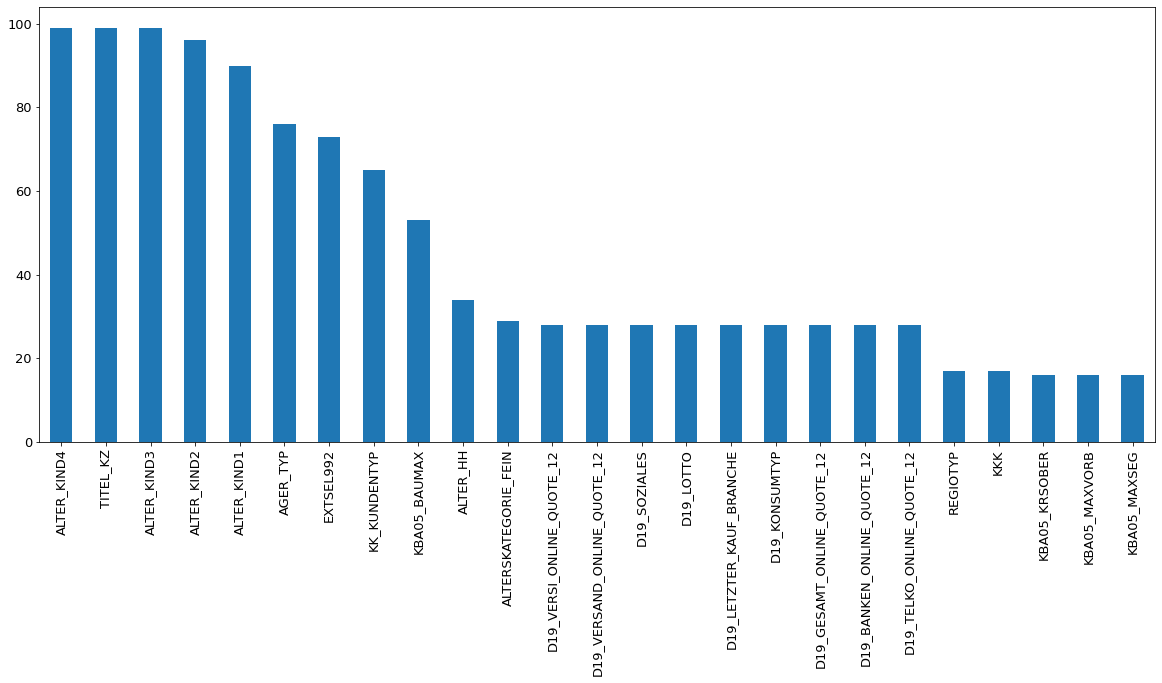

In [37]:
plot_null_counts(azdias)

### Fixing Categorical data

There are various categorical data in the dataset that we need to fix before fitting our model.


##### CAMEO_DEU_2015
The 'CAMEO_DEU_2015' column which specifies the family classification of the person has XX and X values.
Because there is no specification what those columns mean, we would replace them with NaN values.

Then we will one-hot encode the column with binary variables given that the order of the current values is not meaningful.

##### CAMEO_DEUG_2015
This column had numerical values but in string format. We decided to convert them to integers. There is no description provided by Arvato but we decided to keep it as we don't want to have any information loss.

##### CAMEO_INTL_2015

The 'CAMEO_INTL_2015' feature is a ranked numerical feature that combines two categories Wealth (Wealthy, Prosperous, etc) and Life Stage (Pre-Family, Young Family, etc). We decided to split this feature into two features. To do so, we observed that the first value specifies the Wealth and the second specifies the Life Stage.

##### D19_LETZTER_KAUF_BRANCHE 
We one-hot encoded this categorical variable as well.

##### OST_WEST_KZ
Defines East/West so we converted it to binary.

In [38]:
# Find categorical columns
azdias.select_dtypes("object").head(2)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W


In [39]:
# Explore those columns from the attribute file
#attr_val[attr_val["Attribute"] == "CAMEO_DEU_2015"]
#attr_val[attr_val["Attribute"] == "CAMEO_DEUINTL_2015"]

### Fixing Numerical data and Imputing missing values

We used modes of the population data (azdias) to fill missing values in the numerical columns of the DataFrame


## Cleaning the datasets

In [40]:
# Create the clean datasets

modes = dict()
azdias, modes = cleanData(data_root, 'Udacity_AZDIAS_052018.csv', attr_val, modes, create_modes=True, is_customer= False)
customers, _ = cleanData(data_root, 'Udacity_CUSTOMERS_052018.csv', attr_val, modes, create_modes=False, is_customer=True)
mailout_train, _ = cleanData(data_root, 'Udacity_MAILOUT_052018_TRAIN.csv', attr_val, modes, create_modes=False,is_customer= False)
mailout_test, _ = cleanData(data_root, 'Udacity_MAILOUT_052018_TEST.csv', attr_val, modes, create_modes=False, is_customer=False)
print("Clean datasets ready!")


Cleaning Udacity_AZDIAS_052018.csv ...
-Importing file...
-Converting Unknown to NaN...
-Removing NaN values...
-Clean Numerical values
-Clean Categorical values
Cleaning Udacity_CUSTOMERS_052018.csv ...
-Importing file...
-Converting Unknown to NaN...
-Removing NaN values...
-Clean Numerical values
-Clean Categorical values
Cleaning Udacity_MAILOUT_052018_TRAIN.csv ...
-Importing file...
-Converting Unknown to NaN...
-Removing NaN values...
-Clean Numerical values
-Clean Categorical values
Cleaning Udacity_MAILOUT_052018_TEST.csv ...
-Importing file...
-Converting Unknown to NaN...
-Removing NaN values...
-Clean Numerical values
-Clean Categorical values
Clean datasets ready!


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Feature Selection

Working backwards, I want to classify the customers population. To do so I will build an unsupervised model using KMeans clustering which should be able to cluster my dataset and I should be able to see that a number of clusters significantly represents the customer population.
 
In order to build this unsupervised model I need to reduce the dimensionality of the original dataset. The higher the number of dimensions, the less able the KMeans model is able to cluster features. Known as the ‘curse of dimensionality’. In low dimensional datasets, the closest points tend to be much closer than average, but two points are only close if they’re close in every dimension. So when there are lots of dimensions, it’s more likely that the closest points aren’t on average much closer than average.


To reduce the number of features, I will train an xgboost classifier and leverage the feature importance instance method to identify the features between the general population and customers that explain most of the variance.

To do so, I assumed that everyone in the azdias dataset is not a customer (RESPONSE=0) while we added a column in the customers dataset with RESPONSE=1. 



In [41]:
# Add response columns
azdias['RESPONSE'] = 0
customers['RESPONSE'] = 1

In [42]:
# Concatenate the dataset
labeled_azdias_and_customers = pd.concat([azdias,customers])

y = labeled_azdias_and_customers['RESPONSE']
X = labeled_azdias_and_customers.drop('RESPONSE',axis=1)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

del labeled_azdias_and_customers

In [43]:
# Train an xgboost classifier
try:
    model = pickle.load(open("models/xgboost.pkl", 'rb'))
    print("Model loaded")
except:
    model = XGBClassifier(use_label_encoder =False,eval_metric='logloss')
    print("Fitting model")
    model.fit(X_train,y_train)
    pickle.dump(model, open('models/xgboost.pkl','wb'))
    print("model fit!")



Model loaded


AUC: 83.06%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

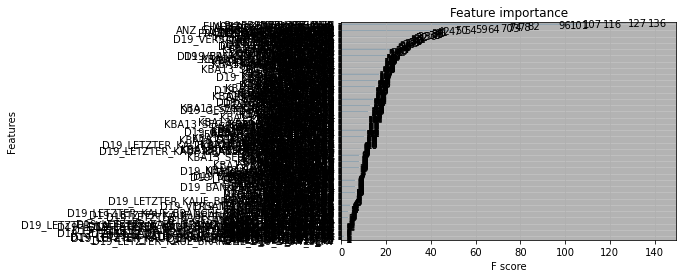

In [44]:
# Use the test set
y_pred_prob = model.predict_proba(X_test)[:,1]
predictions = [round(value) for value in y_pred_prob]
auc = roc_auc_score(y_test, predictions)
print("AUC: %.2f%%" % (auc * 100.0))

plot_importance(model)

In [45]:
# Get the booster from the xgbmodel
booster = model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="gain")


# Rank by importance
importance = {k: v for k, v in sorted(importance.items(), key=lambda item: item[1],reverse=True)}

In [46]:
# XGBOOST - Feature Selection
# Identify the 20 most significant features
feature_selection = list(importance.keys())[0:20]

In [47]:
# Try to refine using random forest
try:
    rf_feature = pickle.load(open("models/rf_feature.pkl", 'rb'))
    print("Model loaded")
except:
    rf_feature = RandomForestClassifier()
    print("Fitting model")
    rf_feature.fit(X_train, y_train)
    pickle.dump(rf_feature, open('models/rf_feature.pkl','wb'))




Model loaded


In [48]:
# Test AUC score
y_pred_prob = rf_feature.predict_proba(X_test)[:,1]
predictions = [round(value) for value in y_pred_prob]
auc = roc_auc_score(y_test, predictions)
print("AUC: %.2f%%" % (auc * 100.0))

AUC: 78.19%


In [49]:
# Find features 
embeded_rf_selector = SelectFromModel(rf_feature, max_features=20,prefit=True)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')


# Random Forest - Feature Selection
embeded_rf_feature

20 selected features


['AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_KONSUMTYP',
 'D19_KONSUMTYP_MAX',
 'D19_SOZIALES',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'KOMBIALTER',
 'LP_FAMILIE_FEIN',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RT_SCHNAEPPCHEN',
 'VK_DISTANZ',
 'VK_ZG11',
 'ALTERSKATEGORIE_GROB']

The xgboost classifier performed better in the test set compared to the random forest. So we will use this to identify the most important features. In any case, both models identified similar significant features.

In [50]:
# Filter by important features to reduce dimensionality for the kmeans algorithm
azdias_sel = azdias[feature_selection]
customers_sel = customers[feature_selection]

### Kmeans data preparation

Kmeans needs the data to be standardized so we will leverage the StandardScaler function of sklearn for datapreprocessing.


In [51]:
# Standardize values to prepare for kmeans
azdias_sel = standardize(azdias_sel)
customers_sel = standardize(customers_sel)

Standardizing values...
Standardizing values...


### Kmeans - optimal number of clusters

To find an optimal number of clusters I used the inertia criterion and Elbow method. The inertia decreases as a function of the number of clusters and plotting the inertia against number of clusters shows the rate of change of inertia. The optimal cluster can be found at an inflection point where the rate of change sharply decreases.

As shown below, there is no clear inflection point, but the most differentation between the population and the customers is seen using 6 clusters. 

Cluster: 1
Cluster: 2
Cluster: 3
Cluster: 4
Cluster: 5
Cluster: 6
Cluster: 7
Cluster: 8
Cluster: 9


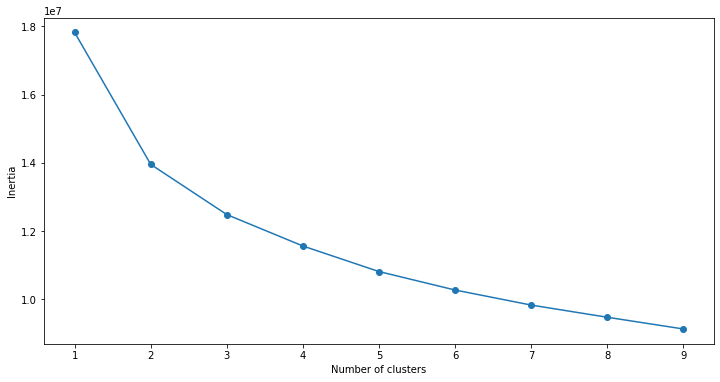

In [52]:
kmeans_res = kmeans(azdias_sel,10)

In [53]:
# Based on the above the optimal number of clusters seem to be 6
num_clusters =6
kmeans = KMeans( n_clusters =num_clusters , init='k-means++')
kmeans.fit(azdias_sel)


KMeans(n_clusters=6)

In [54]:
# Predict clusters using KMEANS
azdias_clusters = kmeans.predict(azdias_sel)
customer_clusters = kmeans.predict(customers_sel)

In [55]:
# Add clusters to azdias data
azdias_sel = pd.concat([azdias_sel.reset_index(),pd.DataFrame({"cluster":azdias_clusters+1})],axis=1)
azdias_sel.drop("index",inplace=True,axis=1)

# Add clusters to customers data
customers_sel = pd.concat([customers_sel.reset_index(),pd.DataFrame({"cluster":customer_clusters+1})],axis=1)
customers_sel.drop("index",inplace=True,axis=1)


In [65]:


azdias_var = pd.DataFrame( {"azdias": (azdias_sel["cluster"].value_counts()/azdias_sel.shape[0])})
customers_var = pd.DataFrame( {"customers": (customers_sel["cluster"].value_counts()/customers_sel.shape[0])})

counts = azdias_var.join(customers_var).sort_index()

del azdias_var
del customers_var

fig = go.Figure(data=[
    go.Bar(name='population', x=counts.index, y=counts.azdias*100,marker_color='darkblue'),
    go.Bar(name='customers', x=counts.index, y=counts.customers*100,marker_color='crimson'),
    
])

fig.update_layout(barmode='group',title_text='% explained by cluster '+str(num_clusters),
                 paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
                 yaxis=dict(ticksuffix="%"))

fig.show()

In [57]:
# Add descriptions from attribute file
descs = pd.read_excel(os.path.join(data_root, 'DIAS Attributes - Values 2017.xlsx'), usecols='B:E', dtype='str')
descs.columns = descs.iloc[0]
descs = descs.iloc[1:]
descs = descs[["Attribute","Description"]].dropna()
descs.head()

,Attribute,Description
1,AGER_TYP,best-ager typology
6,ALTERSKATEGORIE_GROB,age classification through prename analysis
12,ALTER_HH,main age within the household
34,ANREDE_KZ,gender
37,ANZ_HAUSHALTE_AKTIV,number of households in the building


In [60]:
# Export cluster statistics 
for i in range(num_clusters):
    cluster = i + 1
    cluster_comparison(cluster)

In [28]:
del dt
del dt1
del azdias_sel
del customers_sel

#### Customer Characteristics




## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Model Selection

After using various iterations with different ML algorithms (xgboost classifier, random forest) we observed that training a Random Forest algorithm on the whole dataset (mailout_train and customers) gave superior prediction as it had the higher AUC score. 

Below we will use our final model for supervised learning and to create the Kaggle submission dataset.

In [29]:
# Create training dataset
df = pd.concat([azdias, customers], axis=0)
del azdias
del customers

# Add the mailout_train 
df = pd.concat([df, mailout_train], axis=0)

# Create X and y
X = df.drop(['RESPONSE'], axis=1)
y = df['RESPONSE']
del df



In [30]:
# Train a random forest classifier
try:
    model_rf = pickle.load(open("models/rf.pkl", 'rb'))
    print("Model loaded")
except:
    model_rf = RandomForestClassifier()
    print("Fitting model")
    model_rf.fit(X, y)
    pickle.dump(model_rf, open('models/rf.pkl','wb'))



del X
del y

Model loaded


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [31]:
# Use trained model to predict response of the test data
y_pred = model_rf.predict(mailout_test)
y_predprob = model_rf.predict_proba(mailout_test)[:, 1]

# Store in a dataframe
result = mailout_test.index.to_frame()
result['RESPONSE'] = y_predprob

# export result
result.to_csv("result.csv",index=False)

### Kaggle Submission 

As shown below the submission ranks as first out of 438 entries as of 12/26/2021.

Unfortunately, the competition is closed so we cannot be featured in the leaderboard.

![Kaggle Leaderboard](img/kaggle_leaderboard.png)